# Imports and Environment Setup

In [ ]:
!pip install datasets==3.5.0
!pip install pyarrow==20.0.0

In [ ]:
!pip install transformers evaluate accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim

# Initial Environment Configuration

In [ ]:
seed = 0
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
np.random.seed(seed)

**Connecting Google Drive**

In [ ]:
torch.cuda.set_device(0)
device = torch.device("cuda")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Unpacking Datasets**

In [ ]:
if not os.path.exists("/content/nlp"):
    !unzip gdrive/MyDrive/NLP/nlp.zip

Archive:  gdrive/MyDrive/NLP/nlp.zip
   creating: nlp/
  inflating: nlp/answers_students_test_data.tsv  
  inflating: nlp/answers_students_train_data.tsv  
  inflating: nlp/evalF1_no_penalty.pl  
  inflating: nlp/evalF1_penalty.pl   
  inflating: nlp/headlines_test_data.tsv  
  inflating: nlp/headlines_train_data.tsv  
  inflating: nlp/images_phrases_test_data.tsv  
  inflating: nlp/images_phrases_train_data.tsv  
  inflating: nlp/STSint.input.answers-students.wa  
  inflating: nlp/STSint.input.headlines.wa  
  inflating: nlp/STSint.input.images.wa  
  inflating: nlp/STSint.testinput.answers-students.wa  
  inflating: nlp/STSint.testinput.headlines.wa  
  inflating: nlp/STSint.testinput.images.wa  
  inflating: nlp/wellformed.pl       


# Model Creation, Data Transformation, and Tokenization

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = 'roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
from datasets import load_dataset, concatenate_datasets
dataset_before = load_dataset("nlp", data_files={"train":["headlines_train_data.tsv", "images_phrases_train_data.tsv", "answers_students_train_data.tsv"],
                                                 "test":["headlines_test_data.tsv", "images_phrases_test_data.tsv", "answers_students_test_data.tsv"]}, quoting=3)

headlines_before = load_dataset("nlp", data_files={"train":"headlines_train_data.tsv", "test":"headlines_test_data.tsv"}, quoting=3)
images_before = load_dataset("nlp", data_files={"train":"images_phrases_train_data.tsv", "test":"images_phrases_test_data.tsv"}, quoting=3)
answers_before = load_dataset("nlp", data_files={"train":"answers_students_train_data.tsv", "test":"answers_students_test_data.tsv"}, quoting=3)
dataset_before = dataset_before.shuffle(seed=seed)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
import torch.nn.functional as F
types_map = {
    'EQUI': 7,
    'OPPO': 6,
    'SPE1': 5,
    'SPE2': 4,
    'SIMI': 3,
    'REL': 2,
    'ALIC': 1,
    'NOALI': 0,
}
def map_outputs(example):
  y_score = F.one_hot(torch.tensor(example["y_score"]), num_classes=6)
  y_type =  F.one_hot(torch.tensor(types_map[example["y_type"]]), num_classes=8)
  example['labels'] = torch.cat((y_score.view(-1), y_type.view(-1))).float()
  return example

In [ ]:
def map_none_outputs(example):
  example['x1'] = "" if isinstance(example['x1'], type(None)) else example['x1']
  example['x2'] = "" if isinstance(example['x2'], type(None)) else example['x2']
  return example

In [ ]:
def tokenize_and_map(dataset):
    mapped_none_outputs = dataset.map(map_none_outputs)
    output_mapped_dataset = mapped_none_outputs.map( map_outputs, remove_columns=["y_type", "y_score"])
    return output_mapped_dataset.map(lambda example: tokenizer(example["x1"], example["x2"], truncation=True),
                                     batched=True, remove_columns=["x1", "x2"])

In [ ]:
dataset = tokenize_and_map(dataset_before)
headlines = tokenize_and_map(headlines_before)
images = tokenize_and_map(images_before)
answers = tokenize_and_map(answers_before)

Map:   0%|          | 0/10632 [00:00<?, ? examples/s]

Map:   0%|          | 0/6342 [00:00<?, ? examples/s]

Map:   0%|          | 0/10632 [00:00<?, ? examples/s]

Map:   0%|          | 0/6342 [00:00<?, ? examples/s]

Map:   0%|          | 0/10632 [00:00<?, ? examples/s]

Map:   0%|          | 0/6342 [00:00<?, ? examples/s]

Map:   0%|          | 0/3979 [00:00<?, ? examples/s]

Map:   0%|          | 0/2040 [00:00<?, ? examples/s]

Map:   0%|          | 0/3979 [00:00<?, ? examples/s]

Map:   0%|          | 0/2040 [00:00<?, ? examples/s]

Map:   0%|          | 0/3979 [00:00<?, ? examples/s]

Map:   0%|          | 0/2040 [00:00<?, ? examples/s]

Map:   0%|          | 0/4805 [00:00<?, ? examples/s]

Map:   0%|          | 0/2462 [00:00<?, ? examples/s]

Map:   0%|          | 0/4805 [00:00<?, ? examples/s]

Map:   0%|          | 0/2462 [00:00<?, ? examples/s]

Map:   0%|          | 0/4805 [00:00<?, ? examples/s]

Map:   0%|          | 0/2462 [00:00<?, ? examples/s]

Map:   0%|          | 0/1848 [00:00<?, ? examples/s]

Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/1848 [00:00<?, ? examples/s]

Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/1848 [00:00<?, ? examples/s]

Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

# Model Training

In [ ]:
from transformers import TrainingArguments
import evaluate
batch_size = 16

args = TrainingArguments(
    f"{model_name}-finetuned",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01
)

In [ ]:
from torch import nn
from transformers import Trainer

loss_fn = nn.CrossEntropyLoss()

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)

        logits = outputs.get("logits")

        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
metric = evaluate.load('f1');
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    return {'f1_score': metric.compute(predictions=predictions[:, :6].argmax(-1), references=labels[:, :6].argmax(-1), average="micro")['f1'],
            'f1_type':  metric.compute(predictions=predictions[:, 6:].argmax(-1), references=labels[:, 6:].argmax(-1), average="micro")['f1']}

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

def train_model_on_subset(tokenized_dataset,model_name, name, num_labels=14):
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    args = TrainingArguments(
        f"{model_name}-finetuned-{name}",
        eval_strategy = "epoch",
        save_strategy = "epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=10,
        weight_decay=0.01
    )

    trainer = CustomTrainer(
    model,
    args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
    )

    print(f"==> Training model: {name}")
    trainer.train()
    print(f"✔️ Training completed: {name}\n")

**Training the General Model**

In [ ]:
train_model_on_subset(dataset,model_name, "dataset")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-21-2d31e42b9e00>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


==> Trenowanie modelu: dataset


Epoch,Training Loss,Validation Loss,F1 Score,F1 Type
1,2.514000,2.122392,0.868023,0.865815
2,2.098700,1.998747,0.884264,0.900978
3,1.993400,1.973482,0.891990,0.910123
4,1.810700,2.019853,0.898928,0.912330
5,1.756700,2.042820,0.897351,0.915011
6,1.714500,2.078368,0.898928,0.912804
7,1.599700,2.168796,0.893724,0.910754
8,1.562200,2.220315,0.899243,0.912330
9,1.528200,2.247113,0.899558,0.913434
10,1.493200,2.270800,0.901608,0.915484


✔️ Zakończono trenowanie: dataset\n


Training the *Images* Model

In [ ]:
train_model_on_subset(images,model_name, "images")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-63938f44536d>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


==> Trenowanie modelu: images


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mikolaj-olczak12 (mikolaj-olczak12-warsaw-university-of-tecnology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,F1 Score,F1 Type
1,No log,2.219437,0.876117,0.837124
2,2.323500,1.977296,0.879773,0.900487
3,2.323500,1.976825,0.895613,0.906174
4,1.931700,2.036123,0.893582,0.906174
5,1.791100,1.995769,0.904549,0.909423
6,1.791100,2.038429,0.905361,0.909017
7,1.678300,2.022072,0.901706,0.909017
8,1.678300,2.066159,0.898050,0.913891
9,1.612600,2.096754,0.901706,0.909017
10,1.556800,2.109936,0.902112,0.910642


✔️ Zakończono trenowanie: images



Training the *Headlines* Model

In [ ]:
train_model_on_subset(headlines,model_name, "headlines")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-63938f44536d>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


==> Trenowanie modelu: headlines


Epoch,Training Loss,Validation Loss,F1 Score,F1 Type
1,No log,2.488437,0.770588,0.783824
2,No log,2.355576,0.837745,0.815196
3,2.976500,2.267293,0.830392,0.836765
4,2.976500,2.205443,0.880882,0.838235
5,2.280000,2.283958,0.854902,0.831863
6,2.280000,2.298407,0.861275,0.848529
7,2.073500,2.232521,0.872059,0.859314
8,2.073500,2.256019,0.864216,0.863725
9,1.904400,2.252881,0.874510,0.875490
10,1.904400,2.261459,0.873529,0.878922


✔️ Zakończono trenowanie: headlines



Training the *Answers-Students* Model

In [ ]:
train_model_on_subset(answers,model_name, "answers")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-63938f44536d>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


==> Trenowanie modelu: answers


Epoch,Training Loss,Validation Loss,F1 Score,F1 Type
1,No log,2.374574,0.830978,0.800000
2,No log,2.113110,0.887500,0.860326
3,No log,2.115415,0.890217,0.883152
4,No log,2.025549,0.910326,0.896196
5,2.282900,2.013874,0.900000,0.919565
6,2.282900,1.955936,0.909239,0.918478
7,2.282900,2.009558,0.910870,0.926087
8,2.282900,2.010450,0.910326,0.921196
9,1.666300,2.013206,0.910870,0.928261
10,1.666300,2.009595,0.911413,0.925543


✔️ Zakończono trenowanie: answers



In [ ]:
#!cp -r /content/roberta-large-finetuned-answers/checkpoint-1160 /content/gdrive/MyDrive/NLP

In [ ]:
#!mv /content/gdrive/MyDrive/NLP/checkpoint-1160 /content/gdrive/MyDrive/NLP/headlines

In [ ]:
#!rm -rf /content/roberta-large-finetuned-headlines/

Loading the *General* Model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("/content/gdrive/MyDrive/NLP/dataset", num_labels=14)
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=Tru

Loading the *Images* Model

In [ ]:
model_images = AutoModelForSequenceClassification.from_pretrained("/content/gdrive/MyDrive/NLP/images", num_labels=14)
model_images.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=Tru

Loading the *Headlines* Model

In [ ]:
model_headlines = AutoModelForSequenceClassification.from_pretrained("/content/gdrive/MyDrive/NLP/headlines", num_labels=14)
model_headlines.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=Tru

Loading the *Answers-Students* Model

In [ ]:
model_answers = AutoModelForSequenceClassification.from_pretrained("/content/gdrive/MyDrive/NLP/answers", num_labels=14)
model_answers.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=Tru

# Evaluation of the General Model

In [ ]:
trainerHeadlines = CustomTrainer(
    model,
    args,
    train_dataset=headlines['train'],
    eval_dataset=headlines['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainerHeadlines.evaluate()

<ipython-input-27-678fbfde4aab>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainerHeadlines = CustomTrainer(


{'eval_loss': 2.412501573562622,
 'eval_model_preparation_time': 0.0085,
 'eval_f1_score': 0.8828431372549019,
 'eval_f1_type': 0.9014705882352941,
 'eval_runtime': 6.4834,
 'eval_samples_per_second': 314.648,
 'eval_steps_per_second': 19.743}

In [ ]:
trainerImages = CustomTrainer(
    model,
    args,
    train_dataset=images['train'],
    eval_dataset=images['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainerImages.evaluate()

<ipython-input-28-5b6ae1e5f3cc>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainerImages = CustomTrainer(


{'eval_loss': 2.251239061355591,
 'eval_model_preparation_time': 0.0053,
 'eval_f1_score': 0.9069861900893582,
 'eval_f1_type': 0.9114541023558083,
 'eval_runtime': 7.4888,
 'eval_samples_per_second': 328.759,
 'eval_steps_per_second': 20.564}

In [ ]:
trainerAnswers = CustomTrainer(
    model,
    args,
    train_dataset=answers['train'],
    eval_dataset=answers['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainerAnswers.evaluate()

<ipython-input-29-0eb04c3520f7>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainerAnswers = CustomTrainer(


{'eval_loss': 2.1398684978485107,
 'eval_model_preparation_time': 0.0056,
 'eval_f1_score': 0.9152173913043479,
 'eval_f1_type': 0.9364130434782608,
 'eval_runtime': 6.7358,
 'eval_samples_per_second': 273.167,
 'eval_steps_per_second': 17.073}

In [ ]:
trainerDataset = CustomTrainer(
    model,
    args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainerDataset.evaluate()

<ipython-input-30-e5174d2f7278>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainerDataset = CustomTrainer(


{'eval_loss': 2.2707998752593994,
 'eval_model_preparation_time': 0.0087,
 'eval_f1_score': 0.9016083254493851,
 'eval_f1_type': 0.9154840744244718,
 'eval_runtime': 22.026,
 'eval_samples_per_second': 287.932,
 'eval_steps_per_second': 18.024}

Evaluation of the *Images* Model

In [ ]:
trainerImages_uniq = CustomTrainer(
    model_images,
    args,
    train_dataset=images['train'],
    eval_dataset=images['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainerImages_uniq.evaluate()

<ipython-input-31-1a8e7d5e5c6c>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainerImages_uniq = CustomTrainer(


{'eval_loss': 2.109935760498047,
 'eval_model_preparation_time': 0.0058,
 'eval_f1_score': 0.9021121039805037,
 'eval_f1_type': 0.9106417546709992,
 'eval_runtime': 7.4342,
 'eval_samples_per_second': 331.174,
 'eval_steps_per_second': 20.715}

Evaluation of the *Headlines* Model

In [ ]:
trainerHeadlines_uniq = CustomTrainer(
    model_headlines,
    args,
    train_dataset=headlines['train'],
    eval_dataset=headlines['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainerHeadlines_uniq.evaluate()

<ipython-input-32-c07c881df6cd>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainerHeadlines_uniq = CustomTrainer(


{'eval_loss': 2.2614588737487793,
 'eval_model_preparation_time': 0.0056,
 'eval_f1_score': 0.8735294117647059,
 'eval_f1_type': 0.878921568627451,
 'eval_runtime': 6.8197,
 'eval_samples_per_second': 299.134,
 'eval_steps_per_second': 18.769}

Evaluation of the *Answers-Students* Model

In [ ]:
trainerAnswers_uniq = CustomTrainer(
    model_answers,
    args,
    train_dataset=answers['train'],
    eval_dataset=answers['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainerAnswers_uniq.evaluate()

<ipython-input-33-db12d83a41ac>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainerAnswers_uniq = CustomTrainer(


{'eval_loss': 2.0095951557159424,
 'eval_model_preparation_time': 0.0053,
 'eval_f1_score': 0.9114130434782609,
 'eval_f1_type': 0.9255434782608696,
 'eval_runtime': 6.9641,
 'eval_samples_per_second': 264.212,
 'eval_steps_per_second': 16.513}

# Confusion Matrices

In [ ]:
def pr_re(trainer, _model):
  eval_dataloader = trainer.get_eval_dataloader()
  score_preds = torch.empty((0), dtype=torch.int64).to(device)
  score_refs = torch.empty((0), dtype=torch.int64).to(device)

  type_preds = torch.empty((0), dtype=torch.int64).to(device)
  type_refs = torch.empty((0), dtype=torch.int64).to(device)
  _model.eval()
  for batch in eval_dataloader:
      labels = batch["labels"].to(device)
      batch = {k: v.to(device) for k, v in batch.items()}

      with torch.no_grad():
          outputs = _model(**batch)
      outputs = outputs.logits

      score_preds = torch.cat((score_preds, outputs[:, :6].argmax(-1)), dim=0)
      score_refs = torch.cat((score_refs, labels[:, :6].argmax(-1)), dim=0)

      type_preds = torch.cat((type_preds, outputs[:, 6:].argmax(-1)), dim=0)
      type_refs = torch.cat((type_refs, labels[:, 6:].argmax(-1)), dim=0)
  return score_preds,score_refs,type_preds,type_refs

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def img(score_preds,score_refs,type_preds,type_refs, name):
  cf_matrix = confusion_matrix(score_refs.cpu(), score_preds.cpu(), labels=[0, 1, 2, 3, 4,5])
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)
  plt.title(name+" Score")
  plt.xlabel("Predicted Labels")
  plt.ylabel("Real Labels")
  # Build type confusion matrix
  cf_matrix = confusion_matrix(type_refs.cpu(), type_preds.cpu(), labels=[0, 1, 2, 3, 4,5,6,7])
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)
  plt.title(name+" Type")
  plt.xlabel("Predicted Labels")
  plt.ylabel("Real Labels")

In [ ]:
nameToDataset = {'images': trainerImages, 'answers-students':trainerAnswers, 'headlines':trainerHeadlines }
namesList = ['images', 'answers-students', 'headlines']


Confusion Matrix of the General Model

<ipython-input-35-41c1e3dcb084>:16: RuntimeWarning: invalid value encountered in divide
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None])
<ipython-input-35-41c1e3dcb084>:8: RuntimeWarning: invalid value encountered in divide
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None])
<ipython-input-35-41c1e3dcb084>:16: RuntimeWarning: invalid value encountered in divide
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None])
<ipython-input-35-41c1e3dcb084>:16: RuntimeWarning: invalid value encountered in divide
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None])


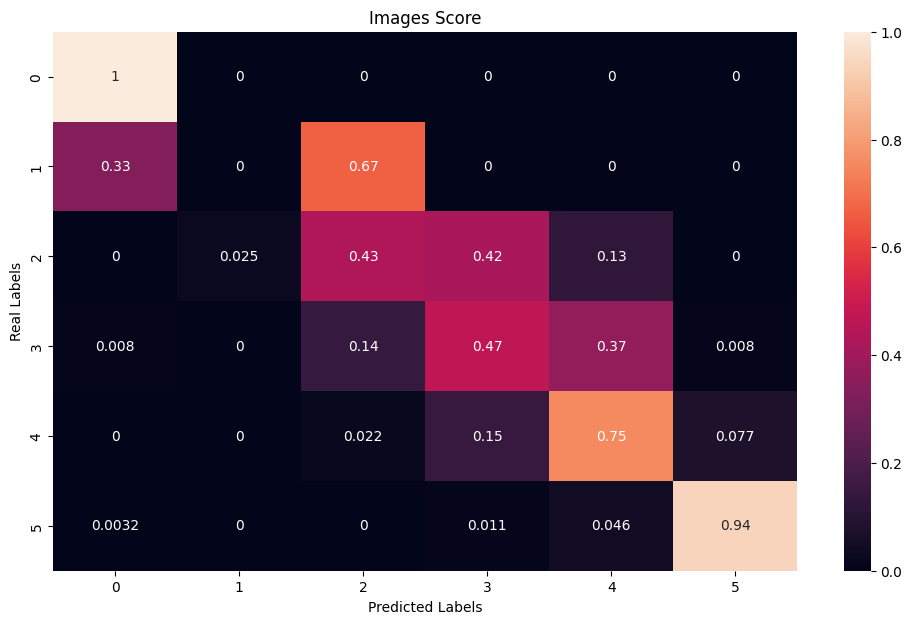

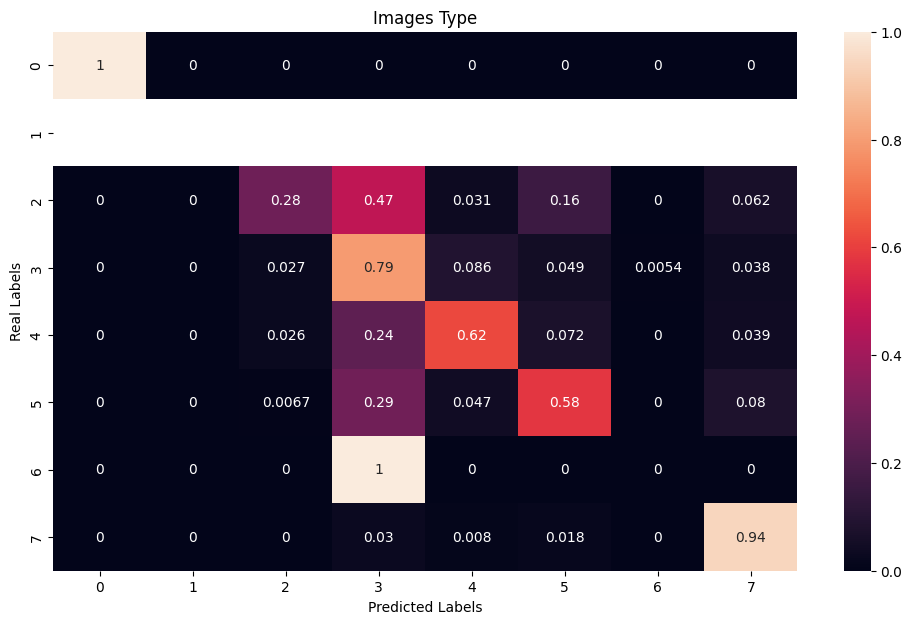

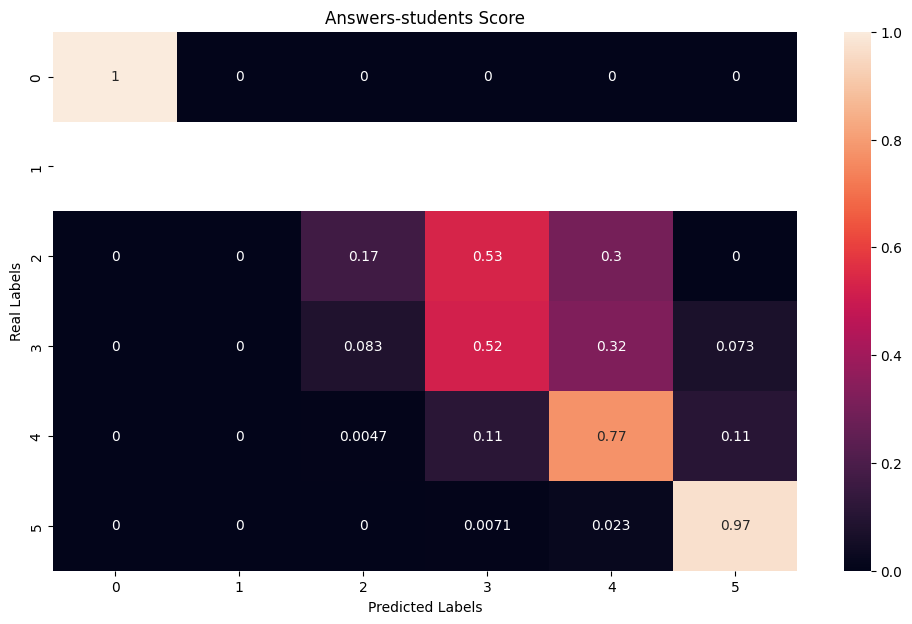

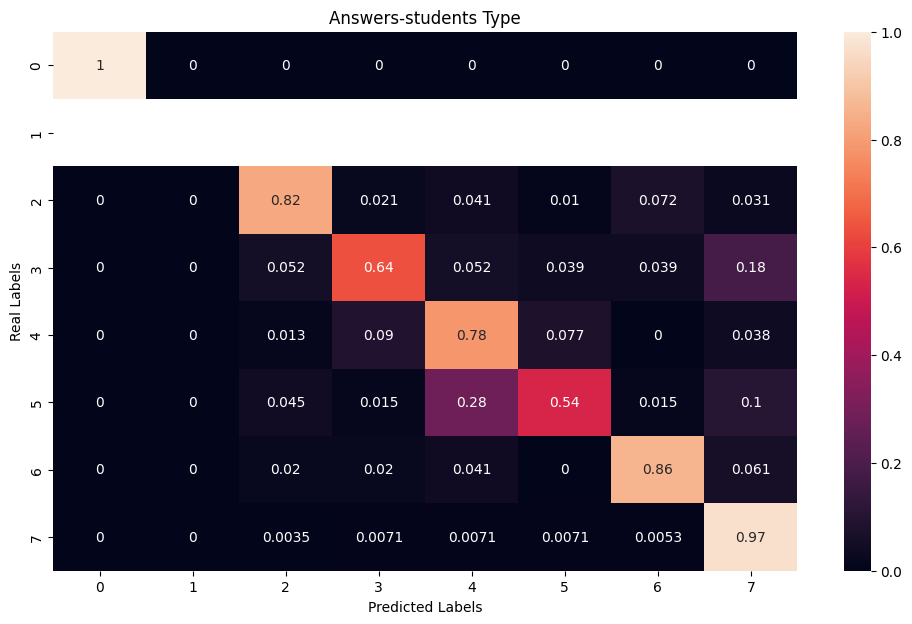

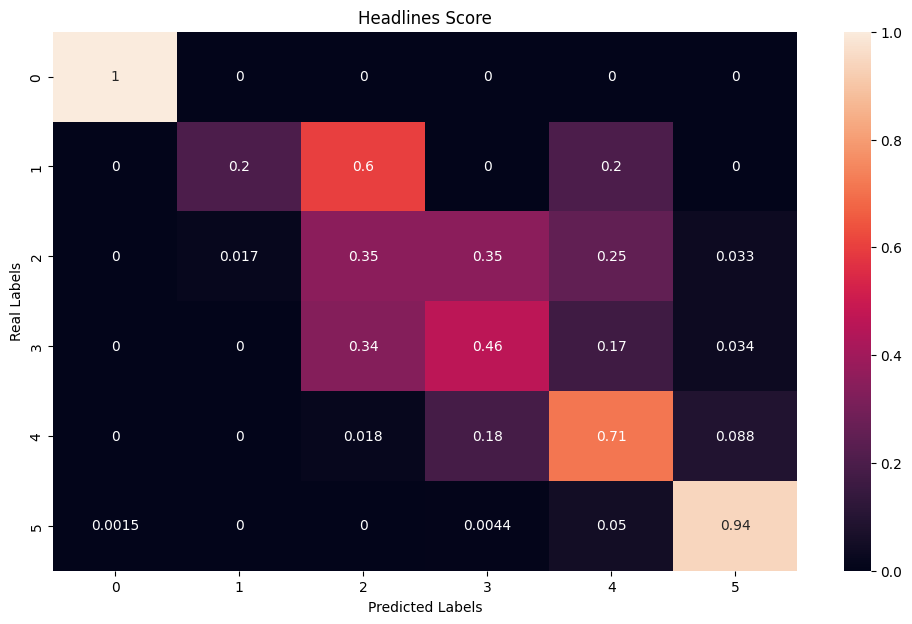

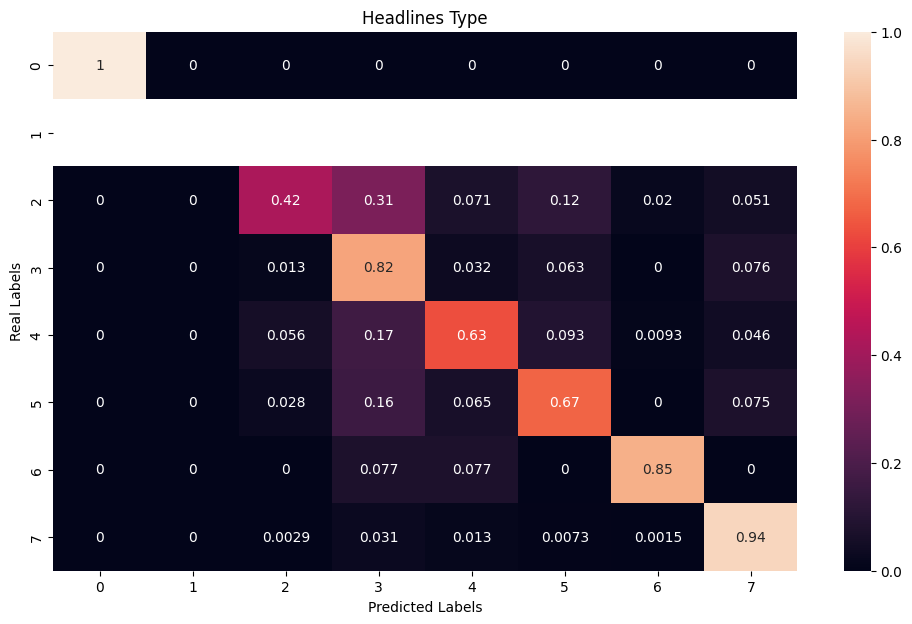

In [ ]:
for name in namesList:
  score_preds,score_refs,type_preds,type_refs = pr_re(nameToDataset[name], model)
  img(score_preds,score_refs,type_preds,type_refs,name.capitalize())

Confusion Matrix of the *Images* Model

<ipython-input-35-41c1e3dcb084>:16: RuntimeWarning: invalid value encountered in divide
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None])


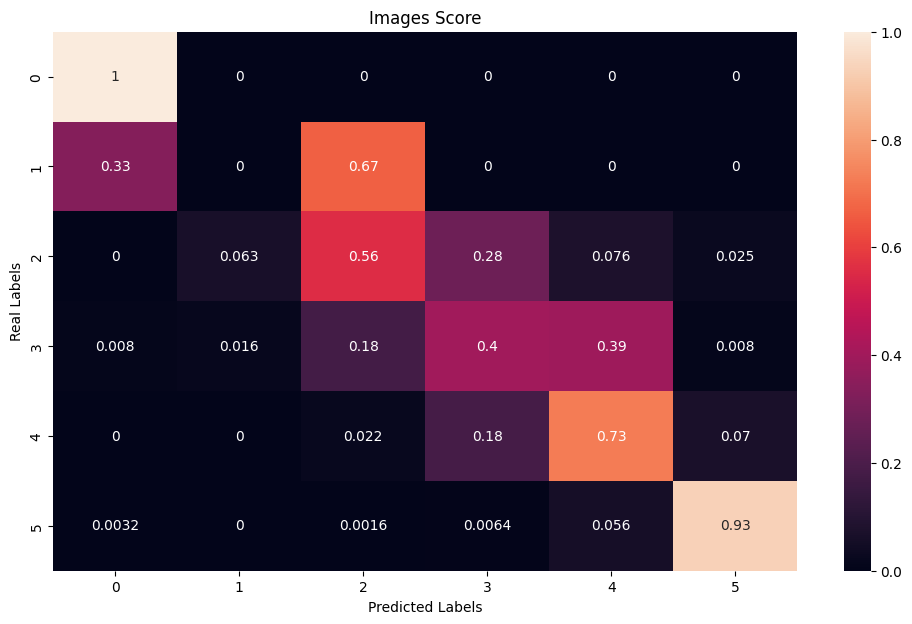

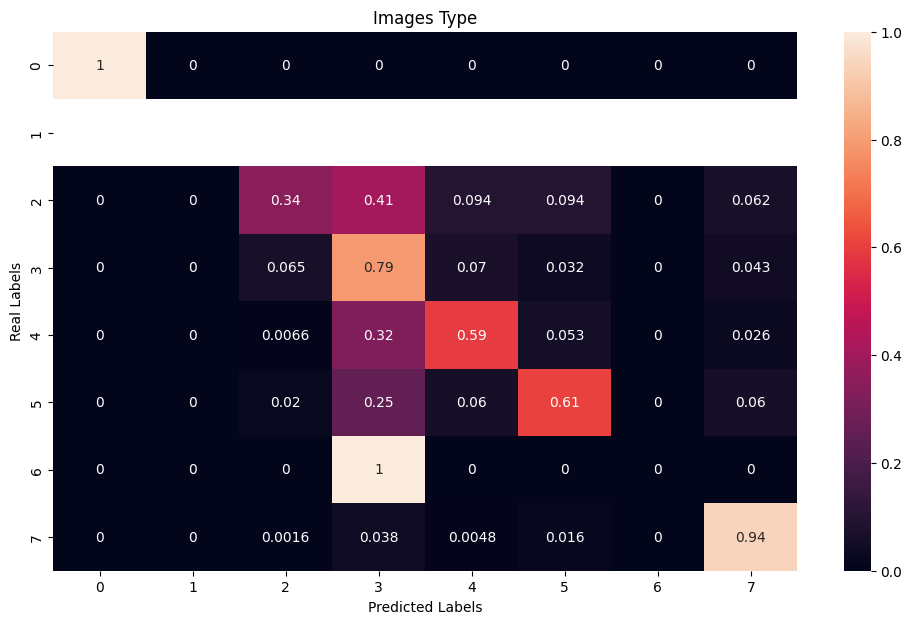

In [ ]:
  score_preds,score_refs,type_preds,type_refs = pr_re(trainerImages_uniq, model_images)
  img(score_preds,score_refs,type_preds,type_refs,'images'.capitalize())

Confusion Matrix of the *Headlines* Model

<ipython-input-35-41c1e3dcb084>:16: RuntimeWarning: invalid value encountered in divide
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None])


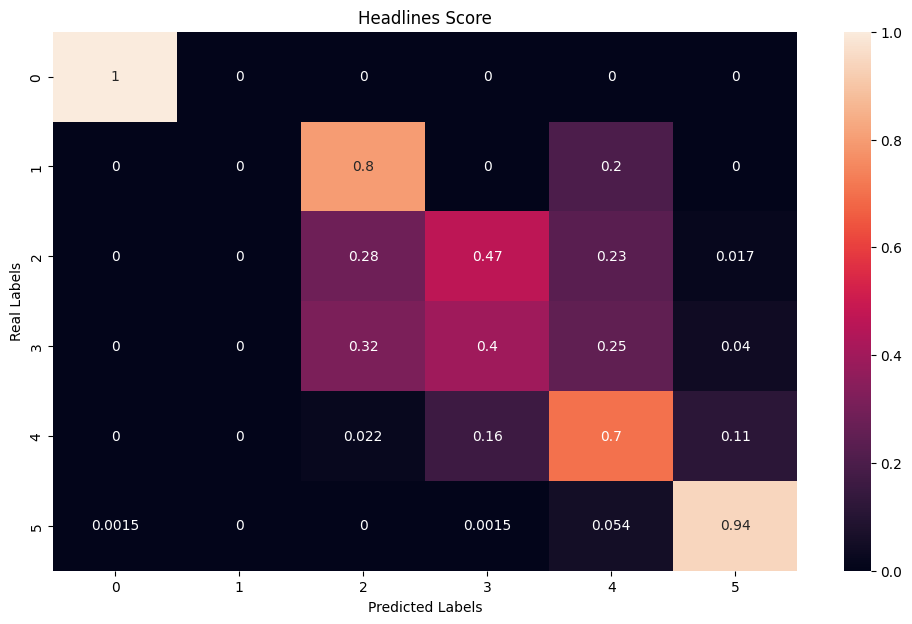

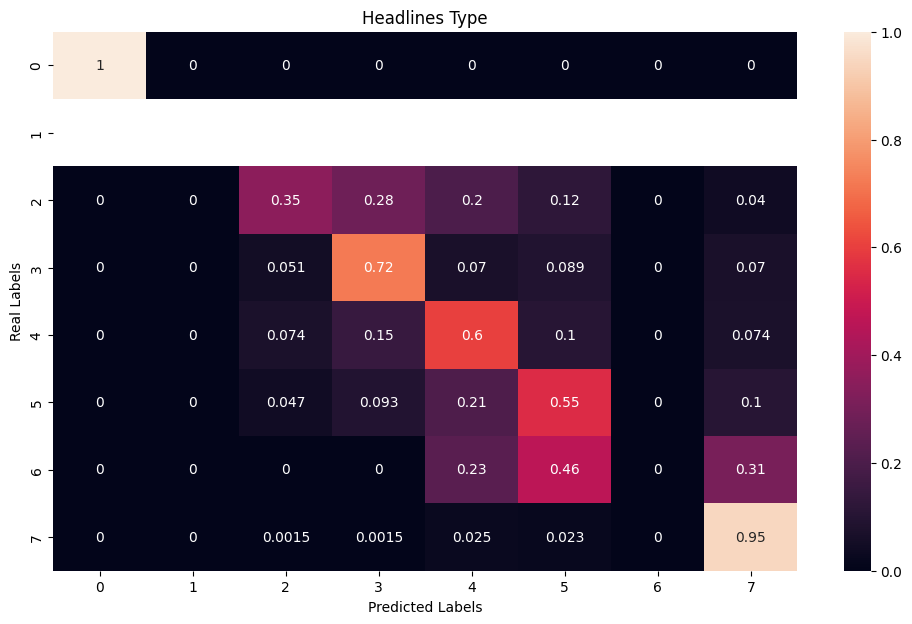

In [ ]:
  score_preds,score_refs,type_preds,type_refs = pr_re(trainerHeadlines_uniq, model_headlines)
  img(score_preds,score_refs,type_preds,type_refs,'headlines'.capitalize())

Confusion Matrix of the *Answers-Students* Model

<ipython-input-35-41c1e3dcb084>:8: RuntimeWarning: invalid value encountered in divide
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None])
<ipython-input-35-41c1e3dcb084>:16: RuntimeWarning: invalid value encountered in divide
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None])


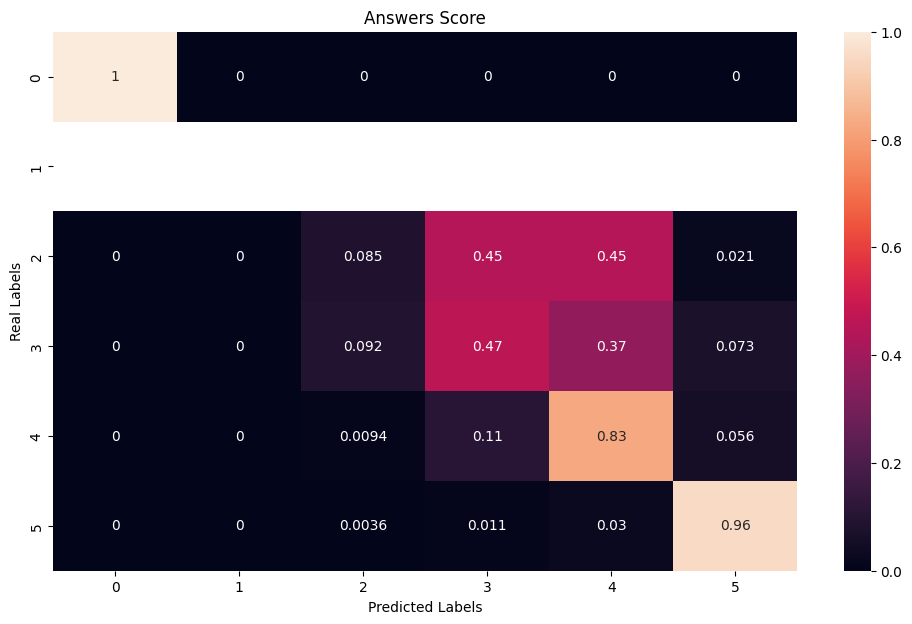

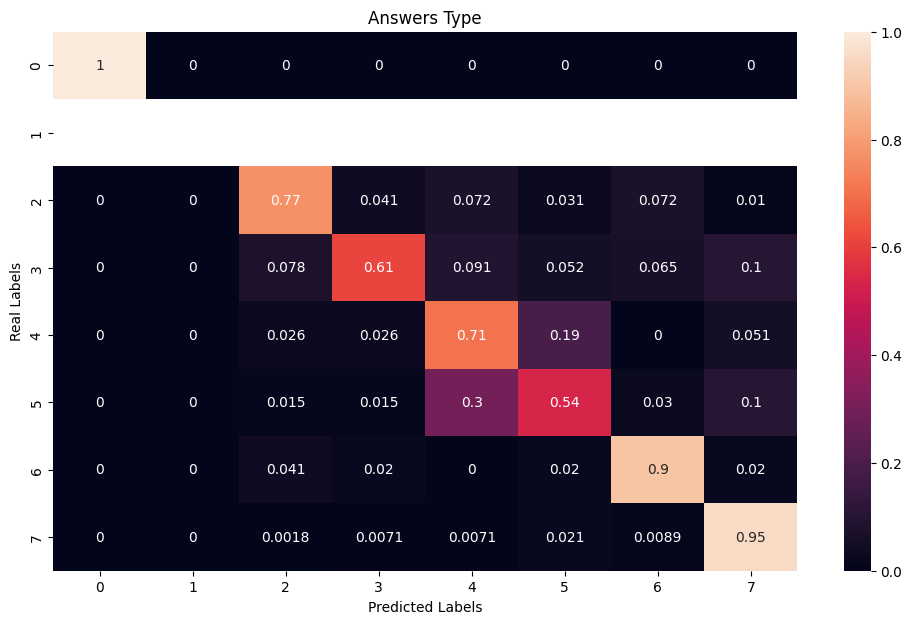

In [ ]:
  score_preds,score_refs,type_preds,type_refs = pr_re(trainerAnswers_uniq, model_answers)
  img(score_preds,score_refs,type_preds,type_refs,'answers'.capitalize())

# Validation with External Files

In [ ]:
fields_sep = ' // '

def preds_to_wa(wa_content, preds_lines):
    wa_lines = wa_content.splitlines()

    idx = 0
    result = []

    for line in wa_lines:
        line_res = line

        if '<==>' in line :
            fields = line.split(fields_sep)
            preds_fields = preds_lines[idx].split()

            fields[1] = preds_fields[1]
            fields[2] = preds_fields[2]

            line_res = fields_sep.join(fields)
            idx += 1
        result.append(line_res)
    return '\n'.join(result)

In [ ]:
from subprocess import check_output
def fileF(DATASET,predictions):
  wa_file = os.path.join(f"/content/nlp/STSint.testinput.{DATASET}.wa")
  wa_output_file = os.path.join(f"/content/nlp/STSint.input.{DATASET}-predictions.wa")

  with open(wa_file) as file:
      wa_test = file.read()

  wa_predictions = preds_to_wa(wa_test, predictions)

  with open(wa_output_file, "w") as file:
      file.write(wa_predictions)

  cmds = [
      f"perl evalF1_penalty.pl {wa_file} {wa_output_file}",
      f"perl evalF1_no_penalty.pl {wa_file} {wa_output_file}",
  ]
  outputs = []
  for cmd in cmds:
    print(f"Executing {cmd}")
    output = check_output(cmd.split(), cwd="/content/nlp").decode()
    outputs.append(output)
    print(output)
  return outputs

In [ ]:
types_d = {number: Type for Type, number in types_map.items()}
def to_str(llist):
  nl = []
  for i in llist:
    nl.append(types_d[i])
  return nl

Validation of the General Model

In [ ]:
for name in namesList:
  score_preds, score_refs, type_preds, type_refs = pr_re(nameToDataset[name], model)
  types = to_str(type_preds.tolist())
  scores = score_preds.tolist()
  predictions = [
      f"{index}\t{Type} {score}\n" for index, (Type, score) in enumerate(zip(types, scores))
  ]
  fileF(name, predictions)

Executing perl evalF1_penalty.pl /content/nlp/STSint.testinput.images.wa /content/nlp/STSint.input.images-predictions.wa
 F1 Ali     1.0000
 F1 Type    0.7928
 F1 Score   0.9538
 F1 Typ+Sco 0.8220

Executing perl evalF1_no_penalty.pl /content/nlp/STSint.testinput.images.wa /content/nlp/STSint.input.images-predictions.wa
 F1 Ali     1.0000
 F1 Type    0.7928
 F1 Score   0.9538
 F1 Typ+Sco 0.7737

Executing perl evalF1_penalty.pl /content/nlp/STSint.testinput.answers-students.wa /content/nlp/STSint.input.answers-students-predictions.wa
 F1 Ali     1.0000
 F1 Type    0.8749
 F1 Score   0.9624
 F1 Typ+Sco 0.8788

Executing perl evalF1_no_penalty.pl /content/nlp/STSint.testinput.answers-students.wa /content/nlp/STSint.input.answers-students-predictions.wa
 F1 Ali     1.0000
 F1 Type    0.8749
 F1 Score   0.9624
 F1 Typ+Sco 0.8565

Executing perl evalF1_penalty.pl /content/nlp/STSint.testinput.headlines.wa /content/nlp/STSint.input.headlines-predictions.wa
 F1 Ali     1.0000
 F1 Type    0.80

Validation of the *Images* Model

In [ ]:
score_preds, score_refs, type_preds, type_refs = pr_re(nameToDataset['images'], model_images)
types = to_str(type_preds.tolist())
scores = score_preds.tolist()
predictions = [
    f"{index}\t{Type} {score}\n" for index, (Type, score) in enumerate(zip(types, scores))
]
fileF('images', predictions)

Executing perl evalF1_penalty.pl /content/nlp/STSint.testinput.images.wa /content/nlp/STSint.input.images-predictions.wa
 F1 Ali     1.0000
 F1 Type    0.7917
 F1 Score   0.9533
 F1 Typ+Sco 0.8251

Executing perl evalF1_no_penalty.pl /content/nlp/STSint.testinput.images.wa /content/nlp/STSint.input.images-predictions.wa
 F1 Ali     1.0000
 F1 Type    0.7917
 F1 Score   0.9533
 F1 Typ+Sco 0.7740



[' F1 Ali     1.0000\n F1 Type    0.7917\n F1 Score   0.9533\n F1 Typ+Sco 0.8251\n',
 ' F1 Ali     1.0000\n F1 Type    0.7917\n F1 Score   0.9533\n F1 Typ+Sco 0.7740\n']

Validation of the *Headlines* Model

In [ ]:
score_preds, score_refs, type_preds, type_refs = pr_re(nameToDataset['headlines'], model_headlines)
types = to_str(type_preds.tolist())
scores = score_preds.tolist()
predictions = [
    f"{index}\t{Type} {score}\n" for index, (Type, score) in enumerate(zip(types, scores))
]
fileF('headlines', predictions)

Executing perl evalF1_penalty.pl /content/nlp/STSint.testinput.headlines.wa /content/nlp/STSint.input.headlines-predictions.wa
 F1 Ali     1.0000
 F1 Type    0.7654
 F1 Score   0.9484
 F1 Typ+Sco 0.8044

Executing perl evalF1_no_penalty.pl /content/nlp/STSint.testinput.headlines.wa /content/nlp/STSint.input.headlines-predictions.wa
 F1 Ali     1.0000
 F1 Type    0.7654
 F1 Score   0.9484
 F1 Typ+Sco 0.7454



[' F1 Ali     1.0000\n F1 Type    0.7654\n F1 Score   0.9484\n F1 Typ+Sco 0.8044\n',
 ' F1 Ali     1.0000\n F1 Type    0.7654\n F1 Score   0.9484\n F1 Typ+Sco 0.7454\n']

Validation of the *Answers-Students* Model

In [ ]:
score_preds, score_refs, type_preds, type_refs = pr_re(nameToDataset['answers-students'], model_answers)
types = to_str(type_preds.tolist())
scores = score_preds.tolist()
predictions = [
    f"{index}\t{Type} {score}\n" for index, (Type, score) in enumerate(zip(types, scores))
]
fileF('answers-students', predictions)

Executing perl evalF1_penalty.pl /content/nlp/STSint.testinput.answers-students.wa /content/nlp/STSint.input.answers-students-predictions.wa
 F1 Ali     1.0000
 F1 Type    0.8504
 F1 Score   0.9582
 F1 Typ+Sco 0.8531

Executing perl evalF1_no_penalty.pl /content/nlp/STSint.testinput.answers-students.wa /content/nlp/STSint.input.answers-students-predictions.wa
 F1 Ali     1.0000
 F1 Type    0.8504
 F1 Score   0.9582
 F1 Typ+Sco 0.8305



[' F1 Ali     1.0000\n F1 Type    0.8504\n F1 Score   0.9582\n F1 Typ+Sco 0.8531\n',
 ' F1 Ali     1.0000\n F1 Type    0.8504\n F1 Score   0.9582\n F1 Typ+Sco 0.8305\n']